# Финальный проект: вариант 2

## Задание 1. A/B - тестирование

### Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### Вопросы

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

#### Загрузим данные и сделаем предобработку

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import pingouin as pg
import scipy
from tqdm.auto import tqdm
from scipy.stats import norm
import pandahouse as ph
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [8]:
# определим функцию для считывания данных 
def get_frame(base_url, public_key, sep=';'):
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep)

In [9]:
groups = get_frame(base_url, public_key_groups)
groups_add = get_frame(base_url, public_key_groups_add, sep=',')
active_studs = get_frame(base_url, public_key_active_studs)
checks = get_frame(base_url, public_key_checks)

#### Посмотрим на данные с разбивкой пользователей по группам в таблице 'groups'

In [10]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [11]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [12]:
groups.duplicated().sum()

0

In [13]:
groups['grp'].value_counts()

grp
B    59813
A    14671
Name: count, dtype: int64

В таблице groups содержится информация о 74484 пользователях. В контрольной группе - 14671, а в целевой группе - 59813 пользователей соответственно. В данных отсутствуют дубликаты и пропущенные значения.

#### Посмотрим на данные, полученные через 2 дня, в таблице 'groups_add'

In [14]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [15]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [16]:
groups_add.duplicated().sum()

0

In [17]:
groups_add.grp.value_counts()

grp
B    70
A    22
Name: count, dtype: int64

В таблице groups_add содержится информация о 92 пользователях, информация о которых была получена спустя два дня после передачи данных. В контрольной группе - 22, а в целевой группе - 70 пользователей соответственно. В данных отсутствуют дубликаты и пропущенные значения.

Добавим пользователей, информацию о которых получили через 2 дня, к уже имеющимся

In [18]:
#объединим таблицы с пользователями
groups_full = pd.concat([groups, groups_add])

In [19]:
# посмотрим нет ли пересечений пользователей между группами
control_group_users = groups_full.loc[groups_full['grp'] == 'A']['id']
test_group_users = groups_full.loc[groups_full['grp'] == 'B']['id']

set(control_group_users).intersection(set(test_group_users)) 

set()

Пересечений пользователей между группами нет

#### Посмотрим на данные пользователей, которые заходили на сайт во время эксперимента в таблице 'active_studs'

In [20]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [21]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [22]:
active_studs.duplicated().sum()

0

В дни проведения эксперимента на сайт зашли 8341 уникальных пользователя. В данных нет дубликатов и пропущенных значений.

#### Посмотрим на данные пользователей об оплате в таблице 'checks'

In [23]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [25]:
np.sort(checks.rev.unique())

array([ 199.    ,  290.    ,  398.    ,  489.    ,  580.    ,  590.    ,
        597.    ,  630.    ,  690.    ,  796.    ,  840.    ,  870.    ,
        880.    ,  990.    , 1039.    , 1050.    , 1140.    , 1160.    ,
       1180.    , 1339.    , 1388.    , 1530.    , 1729.    , 1830.    ,
       1900.    , 1900.0001, 1968.    , 1980.    , 2099.    , 2190.    ,
       2220.    , 2820.    , 2890.    , 2900.    , 2910.    , 3040.    ,
       3260.    , 3660.    , 4650.    ])

В данных есть записи, где оплата равна 1900.0001, что может быть связано с ошибкой округления.

In [26]:
checks.student_id.nunique() 

541

Всего за время проведения эксперимента пользователи совершили 541 покупку. При этом каждый пользователь совершил всего одну покупку.

#### Объединим данные

Объединим данные о группах, активных пользователях и фактах оплаты в один датафрейм

In [27]:
full = groups_full.copy()

Колонка "active" будет содержать информацию об активности пользователя во время эксперимента. Если пользователь заходил на сайт, то занчение равно True, если нет - False

In [28]:
full['active'] = full['id'].isin(active_studs['student_id'])

Колонка "made_purchase" будет содержать информацию о фактах оплаты пользователя во время эксперимента. Если пользователь совершил оплату на сайте, то занчение равно True, если нет - False

In [29]:
full['made_purchase'] = full['id'].isin(checks['student_id'])

In [30]:
#соединим таблицы full и checks и заменим NaN в колонке "rev" на нули
full = full.merge(checks, how='left', left_on='id', right_on='student_id').fillna(0)
full.drop(columns=['student_id'], inplace=True)
full.head()

,id,grp,active,made_purchase,rev
0,1489,B,False,False,0.0
1,1627,A,True,True,990.0
2,1768,B,False,False,0.0
3,1783,B,False,False,0.0
4,1794,A,False,False,0.0


Посмотрим были ли пользователи, которые не заходили на сайт, но совершили оплату

In [31]:
full.loc[(full['active'] == False) & (full['made_purchase'])]

,id,grp,active,made_purchase,rev
39,3185,B,False,True,690.0
121,25973,B,False,True,690.0
125,26280,B,False,True,690.0
223,100645,B,False,True,630.0
254,102534,B,False,True,580.0
...,...,...,...,...,...
72452,5291900,B,False,True,199.0
72753,5331842,B,False,True,290.0
73632,5486319,B,False,True,199.0
74049,5562806,B,False,True,398.0


In [32]:
full.loc[(full['active'] == False) & (full['made_purchase'])].grp.value_counts()

grp
B    120
A     29
Name: count, dtype: int64

В данных есть 149 пользователей, которые не посещали сайт во время эксперимента, но совершили оплату. Среди них 120 пользователей из целевой группы и 29 из контрольной. Исходя из имеющихся данных нельзя сказать почему так произошло, поэтому будем считать эти данные некорректными и исклюим их из дальнейших вычислений.

In [33]:
#Исключим некорректные данные из датафрейма
fail_data_id = full.loc[(full['active'] == False) & (full['made_purchase'])].id
full = full.loc[~full['id'].isin(fail_data_id)]

In [34]:
full.head()

,id,grp,active,made_purchase,rev
0,1489,B,False,False,0.0
1,1627,A,True,True,990.0
2,1768,B,False,False,0.0
3,1783,B,False,False,0.0
4,1794,A,False,False,0.0


In [35]:
full.shape

(74427, 5)

In [36]:
full[['active', 'made_purchase']].sum()

active           8341
made_purchase     392
dtype: int64

In [37]:
full.grp.value_counts()

grp
B    59763
A    14664
Name: count, dtype: int64

#### Посмотрим более детально на чеки пользователей в целевой и контрольной группах

In [38]:
full.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,14664.0,4.965903,95.162132,0.0,0.0,0.0,0.0,3660.0
B,59763.0,6.609006,107.450602,0.0,0.0,0.0,0.0,4650.0


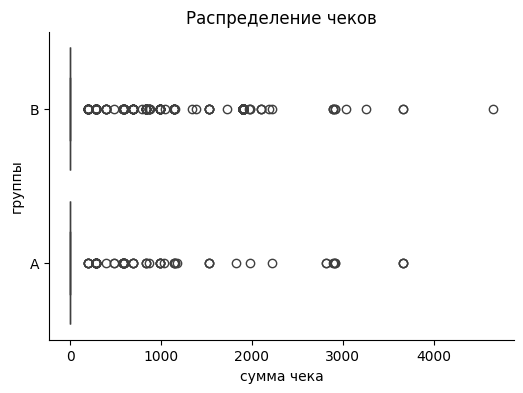

In [39]:
# посмотрим на покупки пользователей в разных группах с помощью boxplot
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=full, x='rev', y='grp', hue='grp')
ax.set_title('Распределение чеков')
ax.set_xlabel('сумма чека')
ax.set_ylabel('группы')
sns.despine()

Такое распределение получилось из-за того, что многие пользователи не совершали покупок. Посмотрим на распределение покупок среди платящих пользователей.

In [40]:
# платящие пользователи
paying_users = full.loc[full['made_purchase']]

In [41]:
paying_users.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


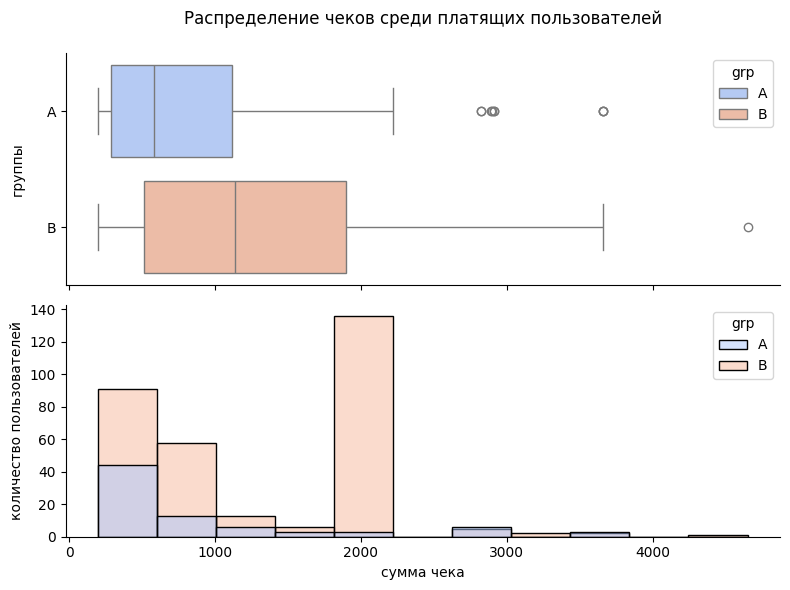

In [42]:
# посмотрим на покупки платящих пользователей в разных группах
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
sns.boxplot(data=full.loc[full['made_purchase']], x='rev', y='grp', hue='grp', palette='coolwarm', legend='full', ax=ax[0])
sns.histplot(data=full.loc[full['made_purchase']], x='rev', hue='grp', palette='coolwarm', ax=ax[1])
ax[0].set_title('Распределение чеков среди платящих пользователей\n')
ax[1].set_xlabel('сумма чека')
ax[1].set_ylabel('количество пользователей')
ax[0].set_ylabel('группы\n')
fig.tight_layout()
sns.despine()

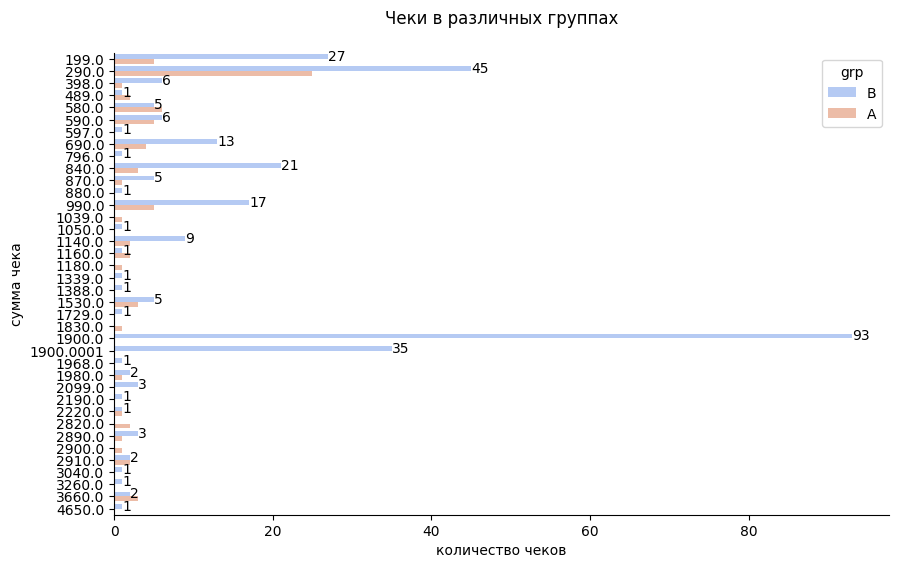

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=full.loc[full['made_purchase']], y='rev', hue='grp', palette='coolwarm')
ax.set_title('Чеки в различных группах\n')
ax.set_xlabel('количество чеков')
ax.set_ylabel('сумма чека')
ax.bar_label(ax.containers[0])
sns.despine()

Найдем долю пользователей, которые заплатили 1900.0

In [44]:
np.round(full.loc[full['made_purchase'] & (full['rev'] == 1900.0)].id.count() /
         full.loc[full['made_purchase']].id.count() * 100, 2)

23.72

По графику видно, что целевой группе пользователи в среднем тратили больше. В обоих группах есть незначительные выбросы. На последнем графике видна некоторая аномалия: 93 (23.72% от всех платящих пользователей) пользователя в целевой группе имеют чек на 1900 ед. и еще 35 пользователей имеют чек на 1900.0001 ед. в то время как в контрольной группе таких пользователей нет.

#### Выводы

Были загружены и изучены данные.  
Данные содержат информацию о 74427 пользователях: 59763 - в целевой и 14664 в контрольной группах соответственно. Из них 8341 пользователей посетили сайт во время эксперимента и 392 (314 в целевой группе и 78 в контрольной) пользователя сделали покупку. 

В данных не обнаружено дубликатов и пропущенных значений. Была найдена некоторая аномалия: обнаружены пользователи (149 пользователей), которые не заходили на сайт во время проведения эксперимента, однако совершили оплату. Было принято решение считать эти данные некорректными и исключить их из дальнейших расчетов. Возможно эти неточности в данных могут быть связаны с ошибками при логировании данных о совершении оплаты. 

Распределение чеков пользователей в целевой группе смещено в сторону более высоких значений, чем в контрольной. Но при этом было обнаружено, что в целевой группе 93 пользователя совершили покупку на 1900.0 ед., что составляет 23.72% от всех платящих пользователей, в то время как в контрольной группе пользователей с такими чеками нет. Это может быть связано с новой механикой оплаты, возможно в новой версии предлагаются какие то акции, где чек или минимальная оплата должна быть 1900.0, но исходя из имеющихся данных это невозможно проверить. Также в целевой группе есть 35 пользователей с чеками на 1900.0001 ед., что наверняка является ошибкой округления при сборе данных.


#### Выбор метрик

Выберем метрики, по которым будем оценивать эффективность новой механики оплаты

1. Конверсия из посещения сайта в покупку

По имеющимся данным можно составить простую воронку сайта:

Все пользователи сайта >> пользователи, зашедвие на сайт >> пользователи, совершившие покупку

Поскольку новая механика оплаты не должна влиять на решение пользователя зайти на сайт, то для оценки эффективности новой механики оплаты будем использовать конверсию из посещения сайта в покупку.

Конверсия в данном случае будет отражать эффективность новой механики оплаты на сайте. Чем понятнее и удобнее сделаны условия оплаты, тем меньше должны быть потери на этом этапе воронки, а значит и конверсия должна быть выше.

2. ARPAU - средняя выручка на активного пользователя

Так как новая механика оплаты не могла повлиять на пользователей не заходивших на сайт, то для расчета средней выручки на пользователя будем учитывать только активных пользователей.

Показывает сколько в среднем активные пользователи тратят на сайте. Эта метрика помогает оценить ценность сайта с точки зрения пользователей. Если новая мехника оплаты стала лучше, то и ARPAU должен вырасти.  

3. ARPPU - средняя выручка на платящего пользователя

Показывает сколько платящие пользователи в среднем тратят на сайте. Эта метрика должна помочь оценить изменения в механике оплаты именно с точки зрения покупателя.


#### Расчет метрик

In [45]:
full.head()

,id,grp,active,made_purchase,rev
0,1489,B,False,False,0.0
1,1627,A,True,True,990.0
2,1768,B,False,False,0.0
3,1783,B,False,False,0.0
4,1794,A,False,False,0.0


Определим конверсию из посещения сайта в покупку в целевой и контрольной группах в процентах

In [46]:
cr = full.loc[full['active']].groupby('grp', as_index=False) \
                                    .agg({'made_purchase':'mean'}) \
                                    .rename(columns={'made_purchase':'cr'}) 
cr['cr'] = cr['cr'].apply(lambda x: round(x * 100, 2))
cr

,grp,cr
0,A,5.07
1,B,4.62


Конверсия в целевой группе уменьшилась по сравнению с контрольной

Расчитаем ARPAU и ARPPU для целевой и контрольной групп

In [47]:
arpau = full.loc[full['active']].groupby(['id', 'grp'], as_index=False) \
            .agg({'rev':'sum'}) \
            .groupby('grp', as_index=False) \
            .agg({'rev':'mean'}) \
            .rename(columns={'rev':'arpau'}) \
            .round(3)
arpau

,grp,arpau
0,A,47.347
1,B,58.059


In [48]:
arppu = full.loc[full['made_purchase']].groupby(['id', 'grp'], as_index=False) \
                                            .agg({'rev':'sum'}) \
                                            .groupby('grp', as_index=False) \
                                            .agg({'rev':'mean'}) \
                                            .rename(columns={'rev':'arppu'}) \
                                            .round(3)
arppu                           

,grp,arppu
0,A,933.590
1,B,1257.879


Соберем метрики вместе

In [49]:
metrics = cr.merge(arpau, on='grp') \
            .merge(arppu, on='grp')
metrics

,grp,cr,arpau,arppu
0,A,5.07,47.347,933.590
1,B,4.62,58.059,1257.879


Конверсия в покупку в целевой группе оказалась меньше, чем в контрольной. В то же время ARPAU (средняя выручка на активного пользователя) и ARPPU (средняя выручка на платящего пользователя) выросли. Выросли также и медиана и мода чеков, что видно из графиков распределений. На первый взгляд можно сказать, что новая механика положительно повлияла на поведение пользователей. Проверим статистическую значимость наблюдаемых различий.

#### Проверка гипотез

#### Гипотеза №1. Конверсия в покупку уменьшилась

Н0: различий в конверсиях в покупку между группами нет  
Н1: конверсия в покупку уменьшилась

Проверим наблюдаемые различия в конверсиях методом Хи-квадрат.

In [50]:
expected, observed, stats = pg.chi2_independence(data=full.loc[full['active']], x='grp', y='made_purchase')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


Все тесты покзали p-value > 0.05, следовательно, у нас недостаточно оснований, чтобы говорить о том, что конверсия в целевой группе статистически значимо уменьшилась.

#### Гипотеза №2 ARPAU увеличилась

Н0: различий в ARPAU между группами нет  
Н1: средняя выручка на активного пользователя (ARPAU) увеличилась

ARPAU это метрика, в основе которой лежит среднее значение, поэтому для проверки гипотезы подходит t-test, так как он сравнивает средние значения. Для использования t-теста необходимо, что бы выполнялись два требования:
1. Дисперсии в контрольной и целевой группе должны быть примерно одинаковыми
2. Распределение статистики (в нашем случае распределение среднего значения метрики) в группах должно быть нормальным

Проверим требование о гомогенности дисперсий, используя тест Левена

In [51]:
# чеки в контрольной и целевой группах для активных пользователей
control_arpau = full.loc[(full['active']) & (full['grp'] == 'A')].rev
test_arpau = full.loc[(full['active']) & (full['grp'] == 'B')].rev

In [52]:
# тест Левена
scipy.stats.levene(control_arpau, test_arpau)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

p-value > 0.05, следовательно дисперсии в контрольной и целевой группах можно считать примерно одинаковыми

Теперь проверим требование о нормальности распределения статистики в контрольной и целевой группах

In [53]:
# средние значения в контрольной и целевой группах
arpau_mean_control = []
arpau_mean_test = []

In [54]:
# просемплируем нашу выборку 10000 раз, чтобы получить распределение среднего значения метрики
for i in range(10000):
    control_sample = full.loc[(full['active']) & (full['grp'] == 'A'), 'rev'].sample(frac=1, replace=True)
    test_sample = full.loc[(full['active']) & (full['grp'] == 'B'), 'rev'].sample(frac=1, replace=True)
    arpau_mean_control.append(control_sample.mean())
    arpau_mean_test.append(test_sample.mean())

In [55]:
# проверим нормальность распределения средних значений для целевой группы
pg.normality(data=arpau_mean_test, method='normaltest')

,W,pval,normal
0,2.876288,0.237368,True


In [56]:
# проверим нормальность данных для контрольной группы
pg.normality(data=arpau_mean_control, method='normaltest')

,W,pval,normal
0,78.110091,1.092972e-17,False


Распределение среднего значения метрики в целевой и контрольной группах не является нормальным

Требование гомогенности дисперсий в контрольной и целевой группах выполняется, однако распределение среднего значения метрики в группах не является нормальным. К тому же, учитывая, значительные различия в размерах выборок (1538 в контрольной и 6803 в целевой) и найденные в данных аномалии, лучше отказаться от использования t-теста и воспользоваться методом bootstrap.

In [57]:
# Объявим функцию, которая позволит проверять гипотезы с помощью bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('#CAB9F1')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=500,linestyle='--', color='grey')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

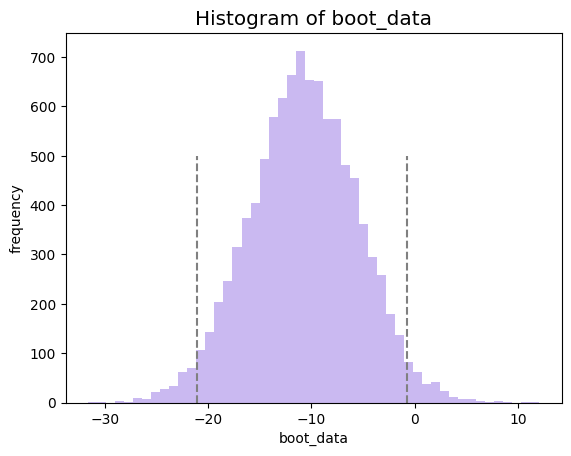

In [58]:
# bootstrap
arpau_bootstrap = get_bootstrap(control_arpau, test_arpau, boot_it=10000)

In [59]:
# p-value
arpau_bootstrap['p_value']

0.03910533524243103

In [60]:
# доверительный интервал
arpau_bootstrap['quants']

,0
0.025,-21.052334
0.975,-0.751654


95%-доверительный интервал не включает 0, следовательно мы можем отвергнуть нулевую гипотезу и с большой долей уверенности утверждать, что ARPAU в целевой группе статистически значимо увеличилась

#### Гипотеза №3 ARPPU увеличилась

Н0: различий в ARPPU между группами нет  
Н1: средняя выручка на платящего пользователя (ARPPU) увеличилась

Метрика ARPPU также основана на среднем значении, поэтому, как и для предыдущей гипотезы, проверим требование на гомогенность дисперсий и требование о нормальности распределения среднего значения метрики в контрольной и целевой группах

Проверим требование о гомогенности дисперсий, используя тест Левена

In [61]:
# чеки в контрольной и целевой группах для платящих пользователей
control_arppu = full.loc[(full['grp'] == 'A') & (full['made_purchase'])].rev
test_arppu = full.loc[(full['grp'] == 'B') & (full['made_purchase'])].rev

In [62]:
# тест Левена
scipy.stats.levene(control_arppu, test_arppu)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

p-value > 0.05, следовательно дисперсии в контрольной и целевой группах можно считать примерно одинаковыми

In [63]:
# средние значения в контрольной и целевой группах
arppu_mean_control = []
arppu_mean_test = []

In [64]:
# просемплируем нашу выборку 10000 раз, чтобы получить распределение среднего значения метрики
for i in range(10000):
    control_sample = full.loc[(full['made_purchase']) & (full['grp'] == 'A'), 'rev'].sample(frac=1, replace=True)
    test_sample = full.loc[(full['made_purchase']) & (full['grp'] == 'B'), 'rev'].sample(frac=1, replace=True)
    arppu_mean_control.append(control_sample.mean())
    arppu_mean_test.append(test_sample.mean())

In [65]:
# проверим нормальность средних значений для целевой группы
pg.normality(data=arppu_mean_test, method='normaltest')

,W,pval,normal
0,1.172512,0.556407,True


In [66]:
# проверим нормальность средних значений для контрольной группы
pg.normality(data=arppu_mean_control, method='normaltest')

,W,pval,normal
0,76.252077,2.767400e-17,False


Требование о нормальности распределения среднего значения метрики выполняется только для целевой группы

Требование гомогенности дисперсий в контрольной и целевой группах выполняется, однако распределение среднего значения метрики является нормальным только для целевой группы. К тому же, учитывая, значительные различия в размерах выборок (78 в контрольной и 314 в целевой) и найденные в данных аномалии, лучше отказаться от использования t-теста и воспользоваться bootstrap.

  0%|          | 0/10000 [00:00<?, ?it/s]

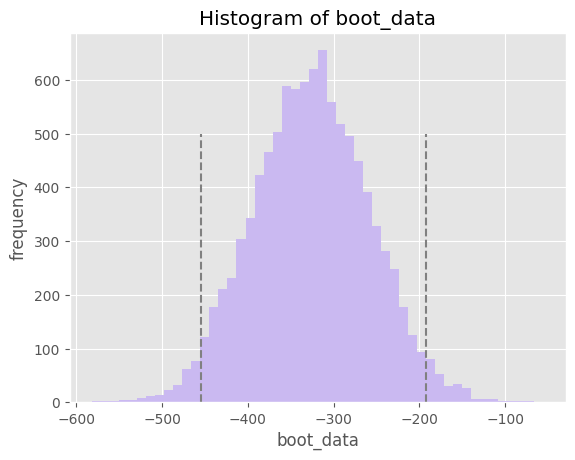

In [67]:
# bootstrap
arppu_bootstrap = get_bootstrap(control_arppu, test_arppu, boot_it=10000)

In [68]:
# p-value
arppu_bootstrap['p_value']

1.5831852499979675e-06

In [69]:
# доверительный интервал
arppu_bootstrap['quants']

,0
0.025,-454.812752
0.975,-191.796669


95%-доверительный интервал не включает 0, следовательно мы можем отвергнуть нулевую гипотезу и с большой долей уверенности утверждать, что ARPPU в целевой группе статистически значимо увеличилась

### Выводы

По результатам анализа данных эксперимента было установлено, что новая механика оплаты на сайте не повысила конверсию в покупку (4.62 в целевой против 5.07 в контрольной). В то же время, показатели средней выручки на активного пользователя (ARPAU) и средней выручки на платящего пользователя (ARPPU) статистически значимо выросли. Выросли также медиана и мода чеков пользователей, что может говорит о том, что пользователи стали тратить больше.

В то же время в данных об оплате была найдена явная аномалия. 93 пользователей в целевой группе (23.72% от всех платящих пользователей) совершили покупку на сумму 1900 ед., а в контрольной таких чеков нет. Этим и обусловлен рост показателей ARPAU и ARPPU в целевой группе. Поэтому нельзя с уверенностью утверждать, что рост метрик связан непосредственно с новой механикой оплаты. Также в целевой группе есть 35 пользователей с чеками на 1900.0001 ед., что наверняка является ошибкой округления при сборе данных.

Я считаю, что раскатывать новую механику оплаты на всех пользователей не стоит. Нужно перепроверить данные и убедиться, что найденные аномалии возникли в результате введения новой механики оплаты, а не являются ошибками в сборе данных. 

## Задание 2. SQL

### Задание 2.1 Очень усердные ученики

### Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.  

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.  
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [70]:
%%html
<style>
table {float:left}
</style>

### Данные

Таблица 'default.peas'

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|:---|
|st_id|int|ID ученика|
|timesst|timestamp|Время решения карточки|
|correct|bool|Правильно ли решена горошина?|
|subject|text|Дисциплина в которой находится горошина|

#### Подключимся к базе данных

Подключимся к базе данных default, используя pandahouse

In [71]:
# создаем соединение
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'}

В качестве текущего месяца будем считать последний месяц представленный в таблице.

#### Запрос

In [72]:
q = '''
    select
        count(st_id) as diligent_students
    from
        (select
            st_id
        from 
            {db}.peas
        where toStartOfMonth(timest) = (select max(toStartOfMonth(timest)) from {db}.peas)
        group by st_id
        having sum(correct) >= 20
        ) as current_month_diligent_students
    '''

In [73]:
diligent_student = ph.read_clickhouse(query=q, connection=connection)
print(f'Количество усердных учеников в текущем месяце: {diligent_student.values[0, 0]}')

Количество усердных учеников в текущем месяце: 136


### Задание 2.2 Оптимизация воронки

### Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.  

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

### Данные

Таблица 'default.peas'

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|:---|
|st_id|int|ID ученика|
|timest|timestamp|Время решения карточки|
|correct|bool|Правильно ли решена горошина?|
|subject|text|Дисциплина в которой находится горошина|

Таблица 'default.studs'

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|:---|
|st_id|int|ID ученика|
|test_grp|text| Метка ученика в данном эксперименте|

Таблица 'default.final_project_check'

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|:---|
|st_id|int|ID ученика|
|sale_time|timestamp|Время покупки|
|money|int|Цена, по которой приобрели данный курс|
|subject|text|Дисциплина курса|

#### Запрос

In [74]:
q = """
    with peas_solved as (                                         
        select                                                    -- peas_solved содержит информацию об общем количестве решенных 
            st_id,                                                -- пользователем задач и решенных только по математике
            sum(correct) as total_solved,
            sumIf(correct, subject='Math') as math_solved
        from {db}.peas
        group by st_id), 

    temp_table as (                                               -- temp_table содержит объединенную информацию по пользователям,
        select
            sts.st_id as st_id,                                   -- количеству решенных задач, ценах купленного курса и дисциплине курса                              
            sts.test_grp as test_grp,
            ps.total_solved as total_solved,
            ps.math_solved as math_solved,
            fpc.money as money,
            fpc.subject as subject
        from
            {db}.studs sts
        left join
            peas_solved as ps
          on sts.st_id = ps.st_id
        left join
            {db}.final_project_check fpc
          on sts.st_id = fpc.st_id)

    select 
        round(sum(money) / uniqExact(st_id), 2) as ARPU,
        round(sumIf(money, total_solved > 10) / countIf(distinct st_id, total_solved > 10), 2) as ARPAU,
        round(countIf(distinct st_id, money > 0) / count(distinct st_id) * 100 ,2) as CR,
        round(countIf(distinct st_id, money > 0 and total_solved > 10) / 
                                        countIf(distinct st_id, total_solved > 10) * 100, 2) as CR_active,
        round(countIf(distinct st_id, money > 0 and math_solved >= 2 and subject='Math') / 
                                        countIf(distinct st_id, math_solved >=2) * 100, 2) as CR_math
        from temp_table
        group by test_grp    
"""

In [75]:
metrics_sql = ph.read_clickhouse(query=q, connection=connection)
metrics_sql

,ARPU,ARPAU,CR,CR_active,CR_math
0,4540.98,10393.70,4.92,11.02,6.12
1,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python

### Условие

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

#### Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv

In [76]:
# создадим текущий датафрейм на основе данных из первого задания без дополнительного файла groups_add.csv
current_df = groups.copy()
current_df['active'] = current_df['id'].isin(active_studs['student_id'])
current_df['made_purchase'] = current_df['id'].isin(checks['student_id'])
current_df = current_df.merge(checks, how='left', left_on='id', right_on='student_id').fillna(0)
current_df.drop(columns=['student_id'], inplace=True)
fail_data_id = current_df.loc[(current_df['active'] == False) & (current_df['made_purchase'])].id
current_df = current_df.loc[~current_df['id'].isin(fail_data_id)]

In [77]:
# ссылки на файлы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [78]:
# определим функцию для считывания данных 
def get_frame(base_url, public_key, sep=';'):

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=sep)

In [79]:
# функция для пересчета метрик
def get_metrics_update(current_df, base_url, link_group_add, link_active_studs, link_checks):
    """
    Функция принимает на вход текущий датафрейм, ссылку на файл с новыми пользователями, а также файлы с активными пользователями и чеками.
    Далее создается датафрейм с новыми пользователями и объединяется с текущим датафреймом.
    На основании нового датафрейма пересчитываются метрики.
    Функция возвращает пересчитанные метрики и новый датафрейм.
    
    """

    # загружаем новых пользователей из дополнительного файла group_add.csv
    groups_add = get_frame(base_url, link_group_add, sep=',')

    # подгружаем файлы с активными пользователями и чеками
    active_studs = get_frame(base_url, link_active_studs)
    checks = get_frame(base_url, link_checks)

    # собираем датафрейм с новыми пользователями
    temp_df = groups_add.copy()
    temp_df['active'] = temp_df['id'].isin(active_studs['student_id'])
    temp_df['made_purchase'] = temp_df['id'].isin(checks['student_id'])
    temp_df = temp_df.merge(checks, how='left', left_on='id', right_on='student_id').fillna(0)
    temp_df.drop(columns=['student_id'], inplace=True)

    # убираем пользователей, которые не заходили на сайт, но совершили оплату
    fail_data_id = temp_df.loc[(temp_df['active'] == False) & (temp_df['made_purchase'])].id
    temp_df = temp_df.loc[~temp_df['id'].isin(fail_data_id)]


    # объединяем новый датафрейм с уже имеющимся
    new_df = pd.concat([current_df, temp_df]).reset_index(drop=True)

    # пересчитываем метрики

    # cr
    cr = new_df.loc[new_df['active']].groupby('grp', as_index=False) \
                                    .agg({'made_purchase':'mean'}) \
                                    .rename(columns={'made_purchase':'cr'}) 
    cr['cr'] = cr['cr'].apply(lambda x: round(x * 100, 2))

    #arpau
    arpu = new_df.loc[new_df['active']].groupby(['id', 'grp'], as_index=False) \
            .agg({'rev':'sum'}) \
            .groupby('grp', as_index=False) \
            .agg({'rev':'mean'}) \
            .rename(columns={'rev':'arpu'}) \
            .round(3)
    #arppu
    arppu = new_df.loc[new_df['made_purchase']].groupby(['id', 'grp'], as_index=False) \
                                            .agg({'rev':'sum'}) \
                                            .groupby('grp', as_index=False) \
                                            .agg({'rev':'mean'}) \
                                            .rename(columns={'rev':'arppu'}) \
                                            .round(3)

    # объединяем полученные метрики
    metrics = cr.merge(arpu, on='grp').merge(arppu, on='grp') 

    # возвращаем метрики и новый датафрейм
    return metrics, new_df

In [80]:
metrics, _ = get_metrics_update(current_df, base_url, public_key_groups_add, public_key_active_studs, public_key_checks)
metrics

,grp,cr,arpu,arppu
0,A,5.07,47.347,933.590
1,B,4.62,58.059,1257.879


#### Реализуем функцию, которая будет строить графики по получаемым метрикам

In [81]:
# функция для построения графиков
def get_charts(metrics_df):
    """Функция получает на вход таблицу с метриками и возвращает графики по этим метрикам"""
    
    fig, axes = plt.subplots(1, 3, figsize=(10,4))
    metrics = metrics_df.columns[1:]
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=metrics_df, x='grp', y=metric, hue='grp', palette='coolwarm', ax=ax) \
                                                    .set(title=metric, xlabel='группы', ylabel='')
    fig.tight_layout()
    sns.despine()
    plt.show()
    

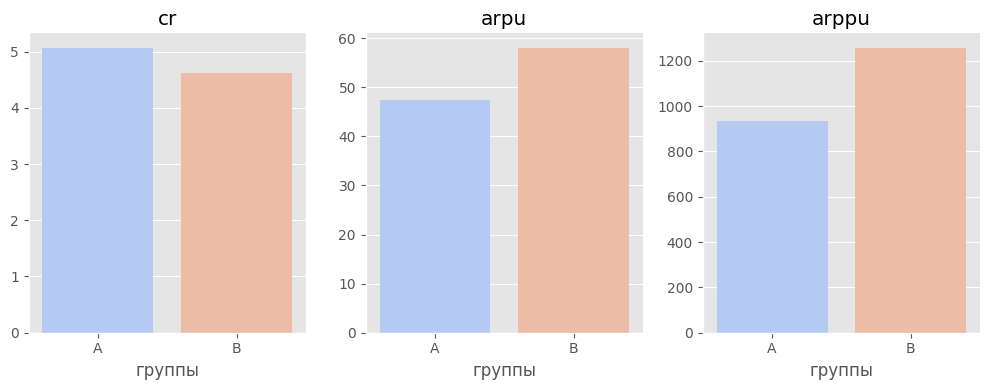

In [82]:
get_charts(metrics)